# Estrategia recomendacion brokers

## Autor: María Carrasco Meléndez, Raquel Fort Serra y Lucía Saiz Lapique

__Práctica 9 y 10__

__Gestión de Activos y Carteras__

__CUNEF__

Esta estrategia de optimización de carteras, o modelo de predicción de rendimientos, a estudiar es la estrategia de recomendación de analistas. De todos los datos proporcionados, esta estrategia utiliza únicamente los datos de recomendación por analistas de cada activo, donde las recomendaciones rondan entre 0 y 5 (0 siendo la peor nota y 5 la mejor).

Contamos con un total de 175 activos a estudiar para la creación de la cartera, además de datos históricos desde mayo de 2012 hasta mayo de 2020. Esta estrategia realiza un ranking de todos los activos en función de la recomendación que tiene cada uno y teniendo en cuenta las posiciones de cada uno a corto o largo plazo (la importancia de cada plazo depende del peso que le demos a cada una y será explicada más adelante). El objetivo no es solo optimizar las rentabilidades de las acciones seleccionadas, sino hacer pruebas a la hora de seleccionar una estrategia u otra. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from pandas_datareader import data as pdr

C:\Users\Luli\Documents\Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Importamos los datos tanto históricos como los específicos para cada estrategia.

In [3]:
datos = pd.read_excel('datos.xlsx')
datos = datos.set_index('Symbol')
datos.head()

,Name,Price,Currency,FX Chang,Sector,Country,Rentab 1Y,Volat 30d,Volat 360d,EV_TO_T12M_EBITDA,EQY_DVD_YLD_12M,NET_OPERATING_ASSETS,RETURN_ON_INV_CAPITAL,EQY_BETA,EQY_REC_CONS,TOT_ANALYST_REC,TOT_BUY_REC,TOT_SELL_REC,TWITTER_SENTIMENT,NEWS_SENTIMENT
Symbol,,,,,,,,,,,,,,,,,,,,
NESN SW Equity,NESTLE SA-REG,101.32,CHF,0.9402,Food,SWITZERLAND,0.018599,0.237874,0.199546,0.166487,0.026648,79763.000000,0.138397,0.812534,3.851852,27,13,1,0.0,0.382784
ROG SW Equity,ROCHE HOLDING AG-GENUSSCHEIN,332.10,CHF,0.9402,Pharmaceuticals,SWITZERLAND,0.221180,0.256552,0.224647,0.128229,0.027100,39591.000000,0.279033,1.031748,3.687500,32,16,5,0.0,0.034268
NOVN SW Equity,NOVARTIS AG-REG,81.18,CHF,0.9402,Pharmaceuticals,SWITZERLAND,-0.082919,0.259980,0.231213,0.150534,0.036339,73355.000000,0.086807,1.073373,3.827586,29,16,4,0.0,0.261707
BATS LN Equity,BRITISH AMERICAN TOBACCO PLC,3275.00,GBp,1.1150,Agriculture,BRITAIN,0.097336,0.341078,0.326400,0.110997,0.062550,106877.000000,0.051704,1.123634,4.473684,19,14,0,0.0,0.112235
FP FP Equity,TOTAL SA,34.04,EUR,1.0000,Oil&Gas,FRANCE,-0.288610,0.523668,0.397920,0.051470,0.077556,131091.815834,0.041398,1.290288,3.466667,30,10,3,0.0,0.000000


In [4]:
historicos = pd.read_excel('historico.xlsx')
historicos['Date'] = pd.to_datetime(historicos['Date'], format="%Y-%m-%d")
historicos = historicos.set_index('Date')
historicos.head()

,NESN SW Equity,ROG SW Equity,NOVN SW Equity,BATS LN Equity,FP FP Equity,RDSA LN Equity,SAN FP Equity,SIE GY Equity,RDSB LN Equity,BAYN GY Equity,...,AXP UN Equity,WMT UN Equity,MSFT UW Equity,MRK UN Equity,NKE UN Equity,VZ UN Equity,KO UN Equity,INTC UW Equity,CSCO UW Equity,PFE UN Equity
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-18,56.65,162.9,44.82,3191.5,37.320,2154.0,56.25,68.937,2208.0,51.695,...,58.04,62.06,31.14,38.40,27.6400,37.66,37.085,27.94,20.06,22.45
2012-04-19,57.20,164.4,45.04,3224.0,36.335,2122.5,55.78,67.697,2183.0,51.567,...,57.57,61.75,31.03,38.36,27.4025,38.15,36.910,27.69,19.92,22.32
2012-04-20,57.10,168.7,45.26,3244.0,36.450,2136.5,56.67,68.491,2202.5,52.875,...,57.45,62.45,32.42,38.73,27.6925,38.73,37.065,27.60,19.91,22.56
2012-04-23,55.50,166.2,45.00,3213.5,35.560,2110.0,55.57,66.766,2179.5,50.553,...,57.32,59.54,32.12,38.27,27.4375,38.57,36.845,27.45,19.68,22.38
2012-04-24,55.50,166.5,44.33,3157.0,35.910,2130.0,56.59,67.648,2200.5,51.262,...,57.63,57.77,31.92,38.27,26.6875,39.50,37.060,27.31,19.42,22.63


Introducimos además el índice de MSCI de yahoo finance para comparar la estrategia final una vez estudiada.

In [5]:
MSCI = pdr.get_data_yahoo('MSCI', 
                          start=datetime.datetime(2012, 4, 18), 
                          end=datetime.datetime(2020, 5, 18))
MSCI.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-12,356.660004,345.260010,350.269989,347.119995,579900.0,346.416687
2020-05-13,347.100006,331.190002,345.209991,335.619995,585500.0,334.940002
2020-05-14,342.359985,331.679993,331.989990,342.049988,379700.0,342.049988
2020-05-15,350.029999,339.079987,340.350006,341.220001,467100.0,341.220001
2020-05-18,353.200012,346.709991,348.589996,346.750000,444100.0,346.750000


In [6]:
MSCI = pd.DataFrame(MSCI['Close'])
MSCI['Rentabilidad'] = MSCI.Close.pct_change() * 100
MSCI.Rentabilidad = MSCI.Rentabilidad.fillna(0)

In [7]:
MSCI['Buy&Hold'] = 100

for i in range(1, len(MSCI)):
    
    MSCI['Buy&Hold'].iloc[i] = MSCI['Buy&Hold'].iloc[i-1]*(1 + (MSCI.Rentabilidad.iloc[i]/100))

C:\Users\Luli\Documents\Anaconda\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Seleccionamos únicamente la variable de recomendaciones de todos los datos proporcionados para crear el ranking y los pesos ya que, en esta estrategia, son los únicos que se deben aplicar. Para ello, creamos un nuevo dataframe que será utilizado de ahora en adelante como los datos originales.

In [8]:
recom = datos[['EQY_REC_CONS']]
recom.index = datos.index
recom.head()

,EQY_REC_CONS
Symbol,
NESN SW Equity,3.851852
ROG SW Equity,3.687500
NOVN SW Equity,3.827586
BATS LN Equity,4.473684
FP FP Equity,3.466667


In [9]:
ranking = recom.rank(ascending=False) 
ranking.head()

,EQY_REC_CONS
Symbol,
NESN SW Equity,82.0
ROG SW Equity,103.0
NOVN SW Equity,84.0
BATS LN Equity,14.0
FP FP Equity,124.0


## Estrategia: mismo peso en corto que en largo

Seleccionamos unos pesos para el largo y corto plazo y se lo aplicamos a cada variable en función del ranking anterior. En este caso, se selecciona aplicarle __el mismo peso al corto plazo que al largo__ pues aunque en el ejercicio no se especifique, es la importancia que se le ha aplicado al resto de estrategias, y así podemos mantener la estructura. Decidimos, además, apalancar esta estrategia (aplicando pesos de 100%) para obtener mejores resultados, pues de hacer lo contrario, con el tiempo, esta estrategia no sería tan óptima.

Una vez seleccionada nuestra estrategia, decidimos aplicarle una importancia de 20 y 20 a cada plazo (corto y largo respectivamente) para que tengan el mismo peso y que así, la estrategia sea neutral al mercado. Además, se le aplica mayor peso al largo (+100%) y menos al corto (-100%) para optimizar la estrategia y que gane valor.

In [10]:
corto = 20.0
largo = 20.0
peso_corto = -1
peso_largo = 1

A continuación, generamos un dataframe con los pesos finales de cada activo, teniendo en cuenta si tienen un mejor ranking en corto o en el largo plazo.



In [11]:
cuenta = datos.Name.count()
cuenta

175

In [12]:
lista = []
for i in ranking['EQY_REC_CONS']:
    m = []
    if i <= largo: 
        pesos = peso_largo/largo
        m.append(pesos)
    elif i >= (cuenta + 1 - corto): 
        pesos = peso_corto/corto
        m.append(pesos)
    else:
        pesos = 0
        m.append(pesos)
    lista.extend(m)
    weights = pd.DataFrame(lista, columns = ['EQY_REC_CONS'])

Obtenemos así los pesos finales y añadimos la columna de símbolos del dataframe inicial para ponerlo como índice. 

In [13]:
weights['Symbol'] = datos.index
weights = weights.set_index('Symbol')
weights.head()

,EQY_REC_CONS
Symbol,
NESN SW Equity,0.00
ROG SW Equity,0.00
NOVN SW Equity,0.00
BATS LN Equity,0.05
FP FP Equity,0.00


## Datos finales de la estrategia

Para la parte final de este estudio, debemos tener en cuenta los datos históricos de cada activo importados al principio del análisis. Estimamos el cambio de porcentaje de cada activo para obtener las renntabilidades diarias de cada una y así obtener los datos finales con los que generaremos la cartera óptima.

In [14]:
df = historicos.pct_change().dropna()
df.head()

,NESN SW Equity,ROG SW Equity,NOVN SW Equity,BATS LN Equity,FP FP Equity,RDSA LN Equity,SAN FP Equity,SIE GY Equity,RDSB LN Equity,BAYN GY Equity,...,AXP UN Equity,WMT UN Equity,MSFT UW Equity,MRK UN Equity,NKE UN Equity,VZ UN Equity,KO UN Equity,INTC UW Equity,CSCO UW Equity,PFE UN Equity
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-19,0.009709,0.009208,0.004909,0.010183,-0.026393,-0.014624,-0.008356,-0.017987,-0.011322,-0.002476,...,-0.008098,-0.004995,-0.003532,-0.001042,-0.008593,0.013011,-0.004719,-0.008948,-0.006979,-0.005791
2012-04-20,-0.001748,0.026156,0.004885,0.006203,0.003165,0.006596,0.015956,0.011729,0.008933,0.025365,...,-0.002084,0.011336,0.044795,0.009645,0.010583,0.015203,0.004199,-0.003250,-0.000502,0.010753
2012-04-23,-0.028021,-0.014819,-0.005745,-0.009402,-0.024417,-0.012403,-0.019411,-0.025186,-0.010443,-0.043915,...,-0.002263,-0.046597,-0.009254,-0.011877,-0.009208,-0.004131,-0.005936,-0.005435,-0.011552,-0.007979
2012-04-24,0.000000,0.001805,-0.014889,-0.017582,0.009843,0.009479,0.018355,0.013210,0.009635,0.014025,...,0.005408,-0.029728,-0.006227,0.000000,-0.027335,0.024112,0.005835,-0.005100,-0.013211,0.011171
2012-04-25,0.002703,0.006006,-0.003835,-0.002534,0.008772,-0.000939,0.006362,0.010318,-0.005226,0.021497,...,0.022211,-0.007097,0.008772,0.004181,0.021358,-0.000506,0.010928,0.020139,0.003605,0.011047


In [15]:
def ratios(recom, weights):
    '''
        returns = dataframe que contiene las rentabilidades diarias de los activos
        weights = pesos de los activos para cada uno de los periodos de tiempo y en total
        -----------------------------------------------------------------------------------
        final = resultado de la estrategia
    '''
    
    # genero los resultados como un indice de base 100
    resultados = [100]
    
    # cojo los pesos totales de la matriz de pesos
    pesos = weights.iloc[:,-1]
    
    # voy calculado los resultados como el anterior mas 1 por la rentabilidad que se obtienen diariamente de las
    # distintas acciones y sus pesos
    for i in range(1, len(recom)):
        
        value = resultados[i-1] * (1 + (recom.iloc[i] * pesos).sum())
        
        resultados.append(value)
    
    # meto en un dataframe para devovler el resultado final y asigno las fechas coo indice
    final = pd.DataFrame(resultados, columns=['Recommendation'])  
    final.set_index(recom.index, inplace=True)
        
    return final

En el dataframe a continuación, podemos observar el resultado de esta estrategia y la graficamos a continuación. Como podemos observar, el resultado ha aumentado considerablemente en 5 años.

In [16]:
final = ratios(df, weights)
final

,Recommendation
Date,
2012-04-19,100.000000
2012-04-20,99.873694
2012-04-23,100.118175
2012-04-24,98.974253
2012-04-25,99.049022
...,...
2020-05-12,124.645844
2020-05-13,124.931879
2020-05-14,126.473023


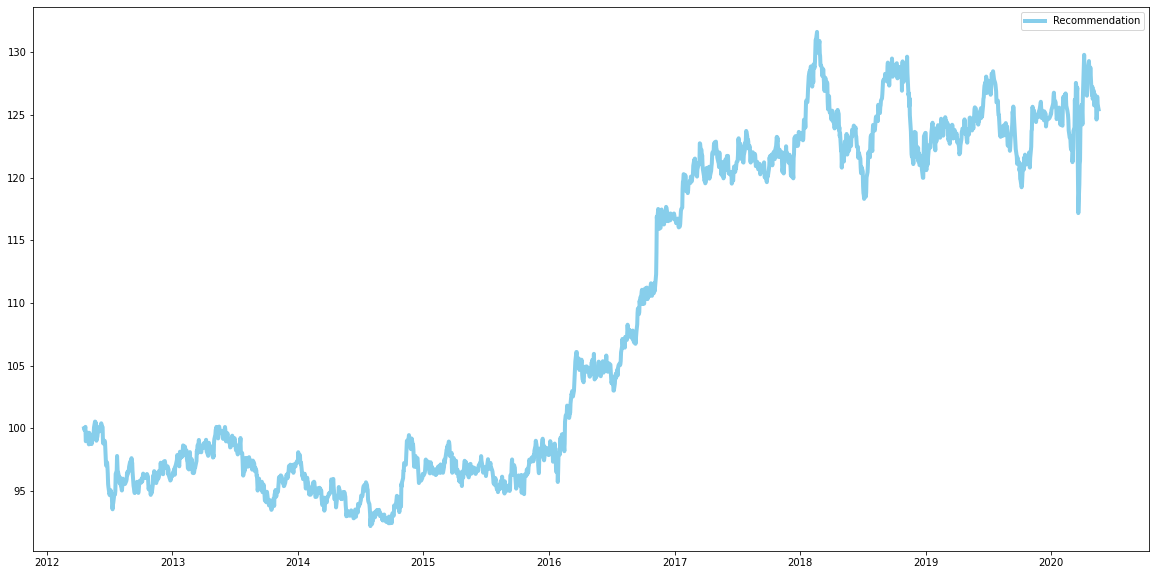

In [17]:
plt.figure(figsize=(20,10))
plt.plot(final.index, final['Recommendation'], marker='', markerfacecolor='blue', markersize=12, color='skyblue', 
         linewidth=4, label ='Recommendation')
plt.legend()

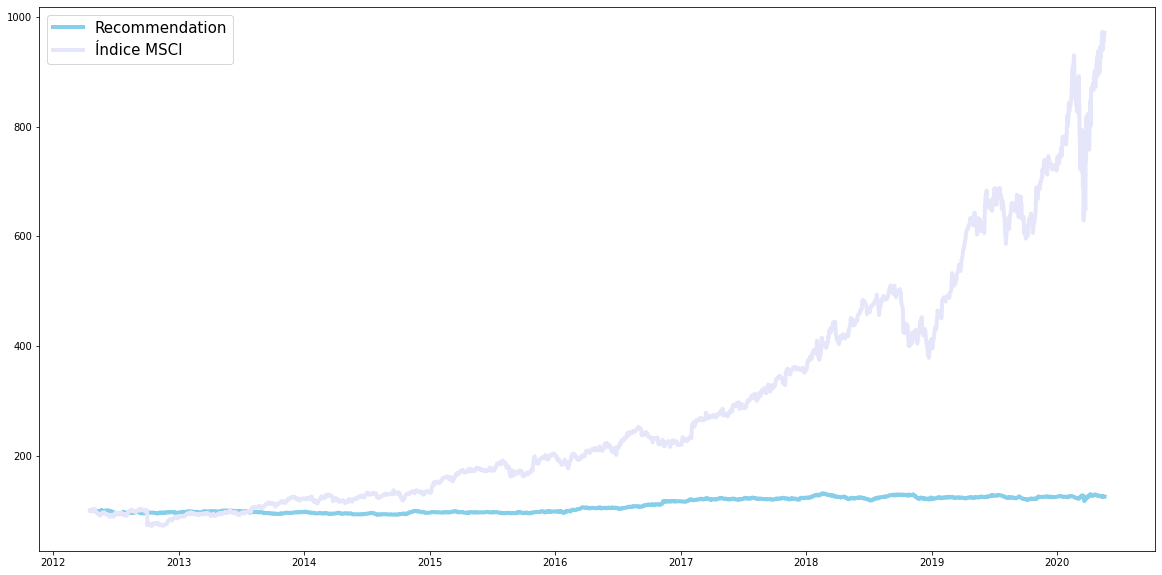

In [18]:
plt.figure(figsize=(20,10))
plt.plot(final.index, final['Recommendation'], marker='', markerfacecolor='blue', markersize=12, color='skyblue', 
         linewidth=4, label ='Recommendation')
plt.plot(MSCI["Buy&Hold"], marker='', markerfacecolor='lavender', markersize=12, color='lavender', 
         linewidth=4, label ='Índice MSCI')
plt.legend(prop={"size":15}, loc="upper left")

Podemos concluir que la selección de pesos para los datos en cuestión es correcta (al aplicar el mayor peso al largo que al corto plazo o viceversa, los resultados eran peores y la subida era mucho menos estable, es decir, que había más volatilidad). Sin embargo, en comparación con el índice seleccionado, nuestra estrategia se mantiene prácticamente constante, es decir, que es neutral al mercado.

In [19]:
final.to_csv('Estrategia_Recommendation_final.csv')